<a href="https://colab.research.google.com/github/lblogan14/hands_on_notes/blob/master/Ch16_reinforcement_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

#Preparations before Running OpenAI Gym
install prerequisiteslike, xvbf, opengl, and other python dev packages:

In [2]:
#installing dependencies
!apt-get -qq -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1 > /dev/null
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null
!pip3 -q install gym
!pip3 install piglet
!pip3 -q install pyglet
!pip3 -q install pyopengl
!pip3 -q install pyvirtualdisplay
!apt install xvfb -y

E: Unable to locate package libcusparse8.0
E: Couldn't find any package by glob 'libcusparse8.0'
E: Couldn't find any package by regex 'libcusparse8.0'
E: Unable to locate package libnvrtc8.0
E: Couldn't find any package by glob 'libnvrtc8.0'
E: Couldn't find any package by regex 'libnvrtc8.0'
Extracting templates from packages: 100%
    100% |████████████████████████████████| 61kB 2.4MB/s 
    100% |████████████████████████████████| 92kB 6.6MB/s 
  Running setup.py bdist_wheel for piglet ... - \ done
  Stored in directory: /root/.cache/pip/wheels/c7/59/a5/5bd1a35a4a4596714c4c7925a1751e7b1580b6ced363fd7969
Successfully built piglet
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.2).
0 upgraded, 0 newly installed, 0 to remove and 3 not upgraded.


##Graphical-User-Interface Amination
The following code prompts a recorded video to see the simulated environment

observation space: Box(4,)
action space: Discrete(2)
initial observation: [-0.01443255  0.01648807 -0.01922772  0.00223616]
next observation: [-0.01410279 -0.17835293 -0.01918299  0.28879103]
reward: 1.0
done: False
info: {}
test episode: 0 R: 10.0
test episode: 1 R: 13.0
test episode: 2 R: 14.0


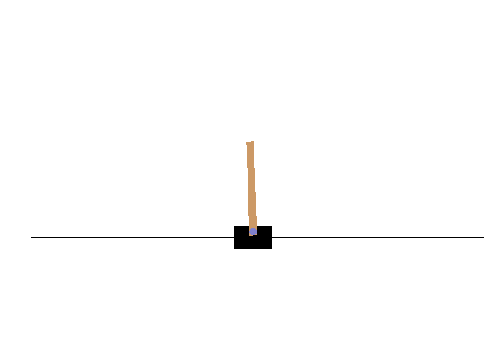

In [3]:
import gym
env = gym.make('CartPole-v0')
print('observation space:', env.observation_space)
print('action space:', env.action_space)

obs = env.reset()
#env.render()
print('initial observation:', obs)

action = env.action_space.sample()
obs, r, done, info = env.step(action)
print('next observation:', obs)
print('reward:', r)
print('done:', done)
print('info:', info)

# Start virtual display
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

frames = []
for i in range(3):
    obs = env.reset()
    done = False
    R = 0
    t = 0
    while not done and t < 200:
        frames.append(env.render(mode = 'rgb_array'))
        obs, r, done, _ = env.step(env.action_space.sample())
        R += r
        t += 1
    print('test episode:', i, 'R:', R)

env.render()


import matplotlib.animation
from IPython.display import HTML

plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(ani.to_jshtml())

#Learning to Optimze Rewards
In Reinforcement Learning, a software *agent* makes *observations* and takes *actions* within an *environment*, and in return it receives *rewards*. Its objective is to learn to act in a way that will maximize its expected long-term rewards.

In short, the *agent* acts in the *environment* and learns by trial and error to maximize its pleasure and minimize its pain.

#Policy Search
*Policy*: the algorithm used by the software agent to determine its actions

The policy can be deterministic or stochastic.

To train and optimize this policy, the *policy parameters* can be tuned just like to tune the hyper-parameters, which is called *policy search*, to search for a best combination of policy parameters in the *policy space*.

One way to explore the policy space is to use *genetic algorithms*.

Another approach is to use optimization techniques, by evaluating the gradients of the rewards with regards to the policy parameters, which is referred to *policy gradients*

#Introduction to OpenAI Gym
To install OpenAI gym,

    pip3 install --upgrade gym

In [0]:
import gym

##MsPacman Example

In [0]:
env = gym.make('MsPacman-v0')

In [0]:
obs = env.reset()

Observations vary depending on the environment. In this case it is an RGB image represented as a 3D NumPy array of shape [width, height, channels] (with 3 channels: Red, Green and Blue). In other environments it may return different objects, as we will see later.

In [0]:
obs.shape

An environment can be visualized by calling its **render()** method, and you can pick the rendering mode (the rendering options depend on the environment). In this example we will set **mode="rgb_array"** to get an image of the environment as a NumPy array:

In [0]:
img = env.render(mode='rbg_array')

In [0]:
plt.figure(figsize=(5,4))
plt.imshow(img)
plt.axis("off")

In this environment, the rendered image is simply equal to the observation (but in many environments this is not the case):

In [0]:
(img == obs).all()

Let's create a little helper function to plot an environment:

In [0]:
def plot_environment(env, figsize=(5,4)):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    plt.show()

Let's see how to interact with an environment. Your agent will need to select an action from an "action space" (the set of possible actions). Let's see what this environment's action space looks like:

In [0]:
env.action_space

**Discrete(9)** means that the possible actions are integers 0 through 8, which represents the 9 possible positions of the joystick (0=center, 1=up, 2=right, 3=left, 4=down, 5=upper-right, 6=upper-left, 7=lower-right, 8=lower-left).

Next we need to tell the environment which action to play, and it will compute the next step of the game. Let's go left for 110 steps, then lower left for 40 steps:

In [0]:
env.reset()
for step in range(110):
    env.step(3) #left
for step in range(40):
    env.step(8) #lower-left

Where are we now?

In [0]:
plot_environment(env)

The **step()** function actually returns several important objects:

In [0]:
obs, reward, done, info = env.step(0)

The observation tells the agent what the environment looks like, as discussed earlier. This is a 210x160 RGB image:

In [0]:
obs.shape

The environment also tells the agent how much reward it got during the last step:

In [0]:
reward

When the game is over, the environment returns done=True:

In [0]:
done

Finally, **info** is an environment-specific dictionary that can provide some extra information about the internal state of the environment. This is useful for debugging, but your agent should not use this information for learning (it would be cheating).

In [0]:
into

Let's play one full game (with 3 lives), by moving in random directions for 10 steps at a time, recording each frame:

In [0]:
frames = []

n_max_steps = 1000
n_change_steps = 10

obs = env.reset()
for step in range(n_max_steps):
    img = env.render(mode="rgb_array")
    frames.append(img)
    if step % n_change_steps == 0:
        action = env.action_space.sample() # play randomly
    obs, reward, done, info = env.step(action)
    if done:
        break

Now show the animation,

In [0]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)

In [0]:
video = plot_animation(frames)
plt.show()

Once you have finished playing with an environment, you should close it to free up resources:

In [0]:
env.close()

##The Cart-Pole Example
The Cart-Pole is a very simple environment composed of a cart that can move left or right, and pole placed vertically on top of it. The agent must move the cart left or right to keep the pole upright.

The **make()** function creates an environment, in this case a CartPole environment.
This is a 2D simulation in which a cart can be accelerated left or right in order to bal‐
ance a pole placed on top of it

In [0]:
env = gym.make('CartPole-v0')

After the environment is created, we must *initialize* it using the **reset()** method. This returns the first observation.

In [0]:
obs_start = env.reset()

In [46]:
obs_start
# 1D array [hori_pos, velocity, angle_of_pole, angular_velocity]

array([ 0.04220047, -0.00552568, -0.03641912, -0.0297098 ])

For the CartPole environment, each observation is a 1D NumPy array containing four floats: these floats represent the cart’s horizontal position (**0.0 = center**), its velocity, the angle of the pole (**0.0 = vertical**), and its angular velocity.

###Fixing the rendering issue
Some environments (including the Cart-Pole) require access to your display, which opens up a separate window, even if you specify the **rgb_array** mode. In general you can safely ignore that window. However, if Jupyter is running on a headless server (ie. without a screen) it will raise an exception. One way to avoid this is to install a fake X server like Xvfb. You can start Jupyter using the xvfb-run command:

    $ xvfb-run -s "-screen 0 1400x900x24" jupyter notebook

If Jupyter is running on a headless server but you don't want to worry about Xvfb, then you can just use the following rendering function for the Cart-Pole:

###Update: once running the preparation step, you don't have to go over this procedure. Just run the following code instead,

In [47]:
env.render()

True

In [48]:
img = env.render(mode='rgb_array')
img.shape # height, width, channels (3=RGB)

(400, 600, 3)

The **render_cart_pole** function is used to update the state of the CartPole.
The **plot_cart_pole** function is used to plot the current state of the CartPole.

In [0]:
from PIL import Image, ImageDraw

try:
    from pyglet.gl import gl_info
    openai_cart_pole_rendering = True   # no problem, let's use OpenAI gym's rendering function
except Exception:
    openai_cart_pole_rendering = False  # probably no X server available, let's use our own rendering function

def render_cart_pole(env, obs):
    if openai_cart_pole_rendering:
        # use OpenAI gym's rendering function
        return env.render(mode="rgb_array")
    else:
        # rendering for the cart pole environment (in case OpenAI gym can't do it)
        img_w = 600
        img_h = 400
        cart_w = img_w // 12
        cart_h = img_h // 15
        pole_len = img_h // 3.5
        pole_w = img_w // 80 + 1
        x_width = 2
        max_ang = 0.2
        bg_col = (255, 255, 255)
        cart_col = 0x000000 # Blue Green Red
        pole_col = 0x669acc # Blue Green Red
        
        pos, vel, ang, ang_vel = obs
        img = Image.new('RGB', (img_w, img_h), bg_col)
        draw = ImageDraw.Draw(img)
        cart_x = pos * img_w // x_width + img_w // x_width
        cart_y = img_h * 95 // 100
        top_pole_x = cart_x + pole_len * np.sin(ang)
        top_pole_y = cart_y - cart_h // 2 - pole_len * np.cos(ang)
        draw.line((0, cart_y, img_w, cart_y), fill=0)
        draw.rectangle((cart_x - cart_w // 2, cart_y - cart_h // 2, cart_x + cart_w // 2, cart_y + cart_h // 2), fill=cart_col) # draw cart
        draw.line((cart_x, cart_y - cart_h // 2, top_pole_x, top_pole_y), fill=pole_col, width=pole_w) # draw pole
        return np.array(img)

def plot_cart_pole(env, obs):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    img = render_cart_pole(env, obs)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

Look at the the original state:

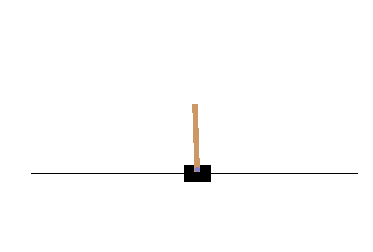

In [50]:
plot_cart_pole(env, obs_start)

Therefore, initially the pole on the cart is upright. Next, we can ask the environment what actions are possible in the CartPole example,

In [51]:
env.action_space

Discrete(2)

**Descrete(2)** means that the possible actions are *intergets 0 and 1*, which represent accelerating left (0) or right(1).

Try to accerlerate the cart toward the left at *one step*:

In [0]:
obs_start = env.reset()

while True:
  obs, reward, done, info = env.step(0)
  if done:
    break

Notice that the **step()** method executes the given action and returns four values:

In [53]:
obs

array([-0.10437639, -1.71452713,  0.24580602,  2.85467917])

In [54]:
obs_start

array([0.02785164, 0.04798936, 0.02333094, 0.01106567])

* **obs** is the new observation. The cart is now moving toward the left (note that **obs[1]<0** compared to the original observation **obs_start[1]>0**). The pole is now tilted toward the right (**obs[2]>0**) and its angular velocity is positive (**obs[3]>0**)

(-0.5, 599.5, 399.5, -0.5)

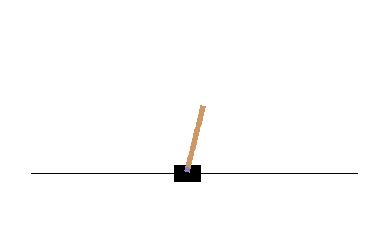

In [55]:
plt.close()
img = render_cart_pole(env, obs)
plt.imshow(img)
plt.axis('off')

In [0]:
obs = env.reset()
while True:
  obs, reward, done, info = env.step(1)
  if done:
    break

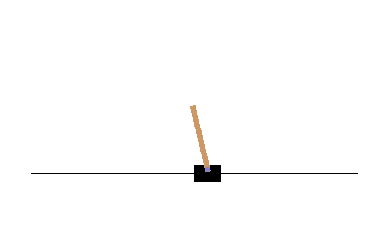

In [57]:
plot_cart_pole(env, obs)

* **reward** returns 1.0 at every step, no matter what you do, so the goal is to keep running as long as possible

* **done** will be **True** when the *episode* is over. This will happen when the pole tilts too much. After that, the environment must be reset before it can be used again.

* **info** is a dictonary providing extra debug information in other environments. This data should not be used for training (it would be cheating)

##Hard-coded policy,
Let’s hardcode a simple policy that accelerates left when the pole is leaning toward the left and accelerates right when the pole is leaning toward the right.

In [0]:
def basic_policy(obs):
  angle = obs[2]
  return 0 if angle<0 else 1

totals = []
for episode in range(500):
  episode_rewards = 0
  obs = env.reset()
  for step in range(1000): # 1000 steps max
    action = basic_policy(obs)
    obs, reward, done, info = env.step(action)
    episode_rewards += reward
    if done:
      break
  totals.append(episode_rewards)

In [59]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(41.84, 8.531963431707851, 25.0, 68.0)

In [0]:
frames = []

n_max_steps = 1000
n_change_steps = 10

obs = env.reset()
for step in range(n_max_steps):
    img = render_cart_pole(env, obs)
    frames.append(img)

    # hard-coded policy
    position, velocity, angle, angular_velocity = obs
    if angle < 0:
        action = 0
    else:
        action = 1

    obs, reward, done, info = env.step(action)
    if done:
        break

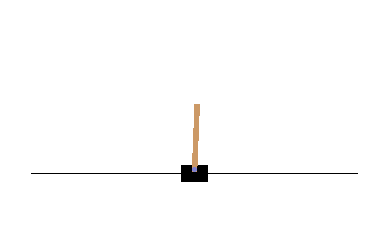

In [61]:
import matplotlib.animation as animation

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,
  
def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)

video = plot_animation(frames)

#Neural Network Policies
Neural network will take an observation as input, and it will output the action to be executed. More precisely, it will estimate a probability for each action, and then we will select an action randomly according to the estimated probabilities.

In the case of the CartPole environment, there are just two possible actions (left or right), so we only need one output neuron. It will output the probability $p$ of action 0 (left), and of course the probability of action 1 (right) will be $1 – p$.

Picking a random action based on the probability given by the neural network lets the agent find the right balance between *exploring* new actions and *exploiting* the actions that are known to work well.

Also note that in this particular environment, the past actions and observations can safely be ignored, since each observation contains the environment’s full state. If there were some hidden state, then you may need to consider past actions and observations as well.

Another example is
when the observations are noisy; in that case, you generally want to use the past few
observations to estimate the most likely current state.

In [0]:
# 1. Specify the network architecture
n_inputs = 4 # == env.observation_space.shape[0]
n_hidden = 4 # it's a simple task, we don't need more than this
n_outputs = 1 # only outputs the probability of accelerating left
initializer = tf.variance_scaling_initializer()

# 2. Build the neural network
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.relu,
                        kernel_initializer=initializer)
outputs = tf.layers.dense(hidden, n_outputs, activation=tf.nn.sigmoid,
                         kernel_initializer=initializer)

# 3. Select a random action based on the estimated probablities
p_left_and_right = tf.concat(axis=1, values=[outputs, 1-outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

init = tf.global_variables_initializer()

Let's randomly initialize this policy neural network and use it to play one game:

In [0]:
n_max_steps = 1000
frames = []

with tf.Session() as sess:
  init.run()
  obs = env.reset()
  for step in range(n_max_steps):
    img = render_cart_pole(env, obs)
    frames.append(img)
    action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
    obs, reward, done, info = env.step(action_val[0][0])
    if done:
      break

env.close()

Now let's look at how well this randomly initialized policy network performed:

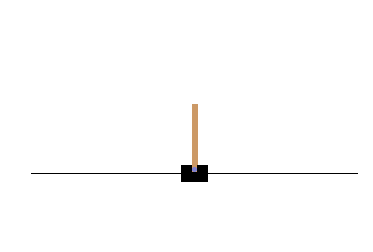

In [64]:
video = plot_animation(frames)
plt.show()

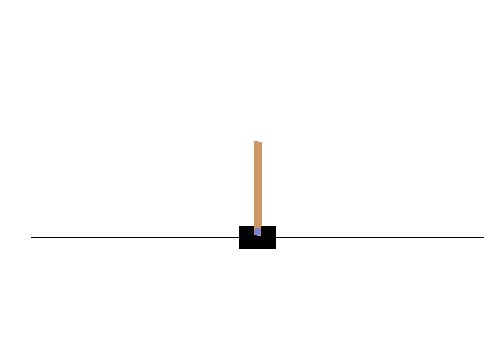

In [65]:
plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(ani.to_jshtml())

The result is pretty bad. 

The neural network will have to learn to do better. First let's see if it is capable of learning the basic policy we used earlier: go left if the pole is tilting left, and go right if it is tilting right. The following code defines the same neural network but we add the target probabilities **y**, and the training operations (**cross_entropy**,  **optimizer** and **training_op**):

In [0]:
reset_graph()

n_inputs = 4
n_hidden = 4
n_outputs = 1

learning_rate = 0.01

initializer = tf.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.float32, shape=[None, n_outputs])

hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu, kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs)
outputs = tf.nn.sigmoid(logits) #probability of action 0 (left)
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(cross_entropy)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

We can make the same net play in 10 different environments in parallel, and train for 1000 iterations. We also reset environments when they are done.

In [0]:
n_environments = 10
n_iterations = 1000

envs = [gym.make('CartPole-v0') for _ in range(n_environments)]
observations = [env.reset() for env in envs]

with tf.Session() as sess:
  init.run()
  for iteration in range(n_iterations):
    # if angle<0 we want proba(left)=1.0, else proba(left)=0
    target_probas = np.array([ ([1.0] if obs[2]<0 else [0.0]) for obs in observations])
    action_val, _ = sess.run([action, training_op], feed_dict={X: np.array(observations), y: target_probas})
    
    for env_index, env in enumerate(envs):
      obs, reward, done, info = env.step(action_val[env_index][0])
      observations[env_index] = obs if not done else env.reset()
  saver.save(sess, './my_policy_net_basic.ckpt')
  
for env in envs:
  env.close()

In [0]:
def render_policy_net(model_path, action, X, n_max_steps=1000):
  frames = []
  env = gym.make('CartPole-v0')
  obs = env.reset()
  with tf.Session() as sess:
    saver.restore(sess, model_path)
    for step in range(n_max_steps):
      img = render_cart_pole(env, obs)
      frames.append(img)
      action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
      obs, reward, done, info = env.step(action_val[0][0])
      if done:
        break
  env.close()
  return frames

INFO:tensorflow:Restoring parameters from ./my_policy_net_basic.ckpt


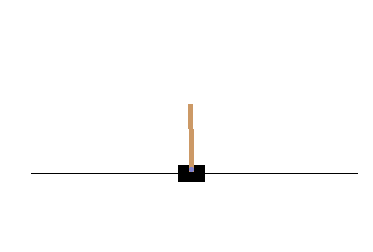

In [73]:
frames = render_policy_net("./my_policy_net_basic.ckpt", action, X)
video = plot_animation(frames)

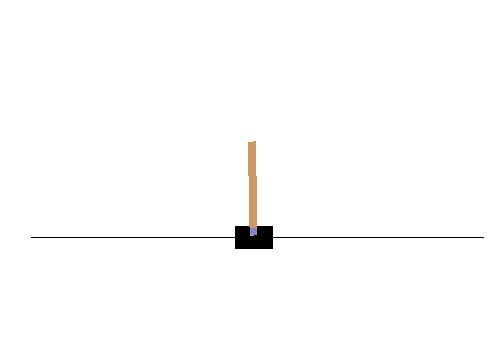

In [74]:
plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(ani.to_jshtml())

Some notes:

* The number of inputs is the size of the observation space
* The neural network applied here is pure MLP
* Use **multinomial()** function to pick a random action. This function independently sampels one (or more) integers, given the log probability of each integer.

For example, **multinomial([tf.log(0.5), tf.log(0.2), tf.log(0.3), num_samples=5])** will output five integers, each of which will have a 50% probability of being 0, 20% of being 1, and 30% of being 2. 

#Evaluating Actions: The Credit Assignment Problem
In Reinforcement Learning the only guidance the agent gets is through rewards, and rewards are typically sparse and delayed.

*Credit assignment problem*: when the agent gets a reward, it is hard for it to know which actions should get credited (or blamed) for it.

A common strategy is to evaluate an action based on the sum of all the rewards that come after it, usualy applying a *discount rate r* at each step.

For example, if an agent decides to go right three times in a row and gets +10 reward after the first step, 0 after the second step, and finally –50 after the third step, then assuming we use a discount rate $r = 0.8$, the first action will have a total score of $10 + r × 0 + r^2× (–50) = –22$.

If the discount rate is close to 0, then future rewards won’t count for much compared to immediate rewards.

Typical discount rates are 0.95 or 0.99. With a discount rate of 0.95, rewards 13 steps into the future count roughly for half as much as immediate rewards (since $0.95^{13} ≈ 0.5$), while with a discount rate of 0.99, rewards 69 steps into the future count for half as much as immediate rewards.

In the CartPole environment, actions have fairly short-term effects, so choosing a discount rate of 0.95 seems reasonable.

To get fairly reliable action scores, we must run many episodes and normalize all the action scores (by subtracting the mean and dividing by the standard deviation). After that, we can reasonably assume that actions with a negative score were bad while actions with a positive score were good.

#Policy Gradients
optimizes the parameters of a policy by following the gradients toward higher rewards

*The REINFORCE algorithm*

1. First, let the neural network policy play the game several times and at each step compute the gradients that would make the chosen action even more likely, but don’t apply these gradients yet.
2. Once you have run several episodes, compute each action’s score (using the method described in the previous paragraph).
3. If an action’s score is positive, it means that the action was good and you want to apply the gradients computed earlier to make the action even more likely to be chosen in the future. However, if the score is negative, it means the action was bad and you want to apply the opposite gradients to make this action slightly less likely in the future. The solution is simply to multiply each gradient vector by the
corresponding action’s score.
4. Finally, compute the mean of all the resulting gradient vectors, and use it to per‐
form a Gradient Descent step.

Using the code in the earlier section, add the target probability, the cost function, and the training operation. 

Since we are acting as though the chosen action is the best possible action, the target probability must be 1.0 if the chosen action is action 0 (left) and 0.0 if it is action 1 (right):

In [0]:
y = 1. - tf.to_float(action)

The cost function and gradient:

In [0]:
learning_rate = 0.01

cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(cross_entropy)
#                            ^this is different than before

Notice that here we are calling the optimizer’s **compute_gradients()** method instead of the
minimize() method because we want to tweak the gradients before we apply them.

The **compute_gradients()** method returns a list of gradient vector/variable pairs (one pair per trainable variable).

Put all the gradients in a list to make it more convenient to obtain their values:

In [0]:
gradients = [grad for grad, variable in grads_and_vars]

During the execution phase, the algorithm will run the policy and at each step it will evaluate these gradient tensors and store their val‐
ues. After a number of episodes it will tweak these gradients as explained earlier (i.e., multiply them by the action scores and normalize them) and compute the mean of the tweaked gradients.

Next, it will need to feed the resulting gradients back to the optimizer so that it can perform an optimization step. This means we need one placeholder per gradient vector.

Moreover, we must create the operation that will apply the updated gradients. For this we will call the optimizer’s **apply_gradients()** function, which takes a list of gradient vector/variable pairs.

Instead of giving it the original gradient vectors, we will give it a list containing the updated gradients (i.e., the ones fed through the gradient placeholders):

In [0]:
gradient_placeholders = []
grads_and_vars_feed = []
  for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))
    
training_op = optimizer.apply_gradients(grads_vars_feed)

##Implementation in TensorFlow
###Construction phase:

In [0]:
reset_graph()

n_inputs = 4
n_hidden = 4
n_outputs = 1

learning_rate = 0.01

initializer = tf.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu, kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs)
outputs = tf.nn.sigmoid(logits)  # probability of action 0 (left)
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

y = 1. - tf.to_float(action)

cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(cross_entropy)

gradients = [grad for grad, variable in grads_and_vars]

gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))

training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Define some functions to compute the total discounted rewardds, given the raw rewards, and to normalize the results across multiple episodes:

In [0]:
def discount_rewards(rewards, discount_rate):
  discounted_rewards = np.zeros(len(rewards))
  cumulative_rewards = 0
  for step in reversed(range(len(rewards))):
    cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
    discounted_rewards[step] = cumulative_rewards
  return discounted_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
  all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
  flat_rewards = np.concatenate(all_discounted_rewards)
  reward_mean = flat_rewards.mean()
  reward_std = flat_rewards.std()
  return [(discounted_rewards - reward_mean)/reward_std for discounted_rewards in all_discounted_rewards]

To understand how these functions work, let's apply the example we mentioned before, in the Credit Assignment Problem section,

"*For example, if an agent decides to go right three times (three actions) in a row and gets +10 reward after the first step, 0 after the second step, and finally –50 after the third step, then assuming we use a discount rate $r = 0.8$,* 

*The **first action** will have a total score of $10 + r × 0 + r^2× (–50) = –22$.*" 

*Then, the **second action** will have a total score of $0 +  r × (-50) = -40$, since there is only one future action.*
*Finally, the **third action** will have a total score of $-50$, since there is no future action.*

See below the returned array:

In [83]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22., -40., -50.])

If we have two episodes,

In [84]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

Notice that the first episode was much worse than the second, so its normalized scores are all negative; all actions from the first episode would be considered bad, and conversely all actions from the second episode would be considered good.

###Execution phase

In [79]:
env = gym.make("CartPole-v0")

n_games_per_update = 10  # train the policy every 10 episodes
n_max_steps = 1000       # max steps per episode
n_iterations = 250       # number of training iterations
save_iterations = 10     # save the model every 10 training iterations
discount_rate = 0.95

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        print("\rIteration: {}".format(iteration), end="")
        all_rewards = []      # all sequences of raw rewards for each episode
        all_gradients = []    # all gradients from the current episode
        for game in range(n_games_per_update):
            current_rewards = []
            current_gradients = []
            obs = env.reset()
            for step in range(n_max_steps):
                action_val, gradients_val = sess.run([action, gradients], feed_dict={X: obs.reshape(1, n_inputs)})
                obs, reward, done, info = env.step(action_val[0][0])
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)

        # At this point we have run the policy for 10 episodes, and we are 
        # ready for a policy update using the algorithm described earlier
        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate=discount_rate)
        feed_dict = {}
        for var_index, gradient_placeholder in enumerate(gradient_placeholders):
            # multiply the gradients by the action scores, and compute the mean
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                      for game_index, rewards in enumerate(all_rewards)
                                          for step, reward in enumerate(rewards)], axis=0)
            feed_dict[gradient_placeholder] = mean_gradients
        sess.run(training_op, feed_dict=feed_dict)
        if iteration % save_iterations == 0:
            saver.save(sess, "./my_policy_net_pg.ckpt")

Iteration: 249

In [0]:
env.close()

INFO:tensorflow:Restoring parameters from ./my_policy_net_pg.ckpt


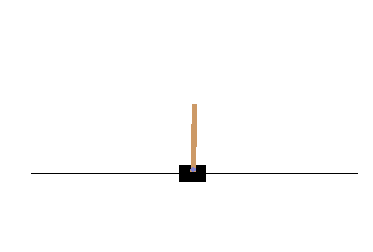

In [80]:
frames = render_policy_net("./my_policy_net_pg.ckpt", action, X, n_max_steps=1000)
video = plot_animation(frames)

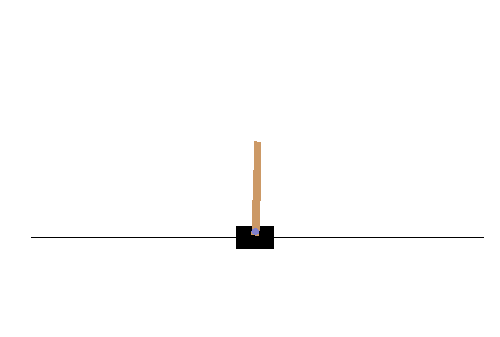

In [81]:
plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(ani.to_jshtml())

#Markov Decision Processes (MDP)
*Markov chain* is a stochastic process with no memory. Such a Such a process has a fixed number of states, and it randomly evolves from one state to another at each step. The probability for it to evolve from a state $s$ to a state $s′$ is fixed, and it depends only on the pair $(s,s′)$, not on past states (the system has no memory).

Let's see the simple example,

In [8]:
transition_probabilities = [
        [0.7, 0.2, 0.0, 0.1],  # from s0 to s0, s1, s2, s3
        [0.0, 0.0, 0.9, 0.1],  # from s1 to ...
        [0.0, 1.0, 0.0, 0.0],  # from s2 to ...
        [0.0, 0.0, 0.0, 1.0],  # from s3 to ...
    ]

n_max_steps = 50

def print_sequence(start_state=0):
    current_state = start_state
    print("States:", end=" ")
    for step in range(n_max_steps):
        print(current_state, end=" ")
        if current_state == 3:
            break
        current_state = np.random.choice(range(4), p=transition_probabilities[current_state])
    else:
        print("...", end="")
    print()

for _ in range(10):
    print_sequence()

States: 0 0 0 0 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 0 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 0 0 0 0 0 1 2 1 3 
States: 0 0 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 0 1 3 
States: 0 0 0 0 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 ...
States: 0 0 0 0 0 0 0 0 0 0 0 1 2 1 2 1 3 
States: 0 0 0 0 0 0 0 0 0 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 ...
States: 0 0 0 0 0 0 0 0 0 0 0 0 0 3 


*Markov decision processes* resemble Markov chains but with a twist: at each step, an agent can choose one of several possible actions $a$, and the transition probabilities depend on the chosen action. Moreover, some state transitions return some reward (positive or negative), and the agent’s goal is to find a policy that will maximize rewards over time.

The *Bellman Optimality Equation* says that if the agent acts optimally, then the optimal value of the current state is equal to the reward it will get on average after taking one optimal aciton, plus the expected optimal value of all possible next states that this action can lead to.

***Bellman Optimality Equation*** is defined as, for all s,
$$V^*(s)=\max_a \sum\limits_{s'}T(s,a,s')[R(s,a,s')+\gamma\cdot V^*(s')]$$
where
* $V^*(s)$ is the optimal state value of any state $s$, which is the sum of all discounted future rewards the agent can expect on average after it reaches a state $s$, assuming it acts optimally.
* $T(s,a,s')$ is the transition probability from state $s$ to state $s'$, given that the agent chose action $a$.
* $R(s,a,s')$ is the reward that the agent gets when it goes from state $s$ to state $s'$, given that the agent chose action $a$.
* $\gamma$ is the discount rate

This equation leads directly to an algorithm that can precisely estimate the optimal state value of every possible state: you first initialize all the state value estimates to zero, and then you iteratively update them using the ***Value Iteration algorithm***:
$V^*_{k+1}(s)=\max_a \sum\limits_{s'}T(s,a,s')[R(s,a,s')+\gamma\cdot V^*_k(s')]$ for all $s$
* $V_k(s)$ is the estimated value of state $s$ at the $k^{th}$ iteration of the algorithm

###Q-Values
are the optimal *state-action values*.

The optimal Q-Value of the state-action pair $(s,a)$, noted $Q^*(s,a)$, is the sum of discounted future rewards the agent can expect on average after it reaches the state $s$ and chooses action $a$, but before it sees the outcome of this action, assuming it acts optimally after that action.

Once again, you start by initializing all the Q-Value estimates to zero, then you update them using the ***Q-Value Iteration algorithm***:
$Q_{k+1}(s,a)\leftarrow \sum\limits_{s'}T(s,a,s')[R(s,a,s')+\gamma\cdot \max_{a'}Q_k(s', a')]$ for all $(s,a)$

Once you have the optimal Q-Values, defining the optimal policy, noted $\pi^*(s)$, is trivial: when the agent is in state $s$, it should choose the action with the highest Q-Value for that state: $\pi^*(s)= \arg\max_a Q^*(s,a)$

See a simple example,

In [0]:
transition_probabilities = [
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]], # in s0, if action a0 then proba 0.7 to state s0 and 0.3 to state s1, etc.
        [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
        [None, [0.8, 0.1, 0.1], None],
    ]

rewards = [
        [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
        [[0, 0, 0], [+40, 0, 0], [0, 0, 0]],
    ]

possible_actions = [[0, 1, 2], [0, 2], [1]]

In [11]:
def policy_fire(state):
    return [0, 2, 1][state]

def policy_random(state):
    return np.random.choice(possible_actions[state])

def policy_safe(state):
    return [0, 0, 1][state]
  
class MDPEnvironment(object):
    def __init__(self, start_state=0):
        self.start_state=start_state
        self.reset()
    def reset(self):
        self.total_rewards = 0
        self.state = self.start_state
    def step(self, action):
        next_state = np.random.choice(range(3), p=transition_probabilities[self.state][action])
        reward = rewards[self.state][action][next_state]
        self.state = next_state
        self.total_rewards += reward
        return self.state, reward

def run_episode(policy, n_steps, start_state=0, display=True):
    env = MDPEnvironment()
    if display:
        print("States (+rewards):", end=" ")
    for step in range(n_steps):
        if display:
            if step == 10:
                print("...", end=" ")
            elif step < 10:
                print(env.state, end=" ")
        action = policy(env.state)
        state, reward = env.step(action)
        if display and step < 10:
            if reward:
                print("({})".format(reward), end=" ")
    if display:
        print("Total rewards =", env.total_rewards)
    return env.total_rewards

for policy in (policy_fire, policy_random, policy_safe):
    all_totals = []
    print(policy.__name__)
    for episode in range(1000):
        all_totals.append(run_episode(policy, n_steps=100, display=(episode<5)))
    print("Summary: mean={:.1f}, std={:1f}, min={}, max={}".format(np.mean(all_totals), np.std(all_totals), np.min(all_totals), np.max(all_totals)))
    print()

policy_fire
States (+rewards): 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) ... Total rewards = 50
States (+rewards): 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) ... Total rewards = 40
States (+rewards): 0 1 (-50) 2 2 (40) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) ... Total rewards = 50
States (+rewards): 0 (10) 0 (10) 0 (10) 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 (10) 0 (10) ... Total rewards = 320
States (+rewards): 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 1 (-50) 2 (40) ... Total rewards = 0
Summary: mean=121.7, std=130.706951, min=-250, max=550

policy_random
States (+rewards): 0 0 0 0 1 1 (-50) 2 1 1 (-50) 2 (40) ... Total rewards = -80
States (+rewards): 0 0 0 0 (10) 0 0 0 (10) 0 0 0 ... Total rewards = 20
States (+rewards): 0 0 0 1 1 (-50) 2 1 (-50) 2 2 (40) 0 ... Total rewards = -190
States (+rewards): 0 0 1 1 1 1 1 (-50) 2 (40) 0 0 (10) ... Total rewards = -60
States (+rewards): 0 0 (10) 0 1 1 1 (-50) 2 (40) 0 0 0 ... Total re

Now we can see Q-Values,


In [0]:
nan=np.nan # represents impossible actions
T = np.array([ # shape=[s, a, s']
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
        [[0.0, 1.0, 0.0], [nan, nan, nan], [0.0, 0.0, 1.0]],
        [[nan, nan, nan], [0.8, 0.1, 0.1], [nan, nan, nan]],
])

R = np.array([ # shape=[s, a, s']
        [[10., 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]],
        [[10., 0.0, 0.0], [nan, nan, nan], [0.0, 0.0, -50.]],
        [[nan, nan, nan], [40., 0.0, 0.0], [nan, nan, nan]],
])

possible_actions = [[0, 1, 2], [0, 2], [1]]

In [0]:
Q = np.full((3,3), -np.inf) # -inf for impossible actions
for state, actions in enumerate(possible_actions):
  Q[state, actions] = 0.0 # Initial value = 0.0 for all possible actions
  
learning_rate = 0.01
discount_rate = 0.95
n_iterations = 100

for iteration in range(n_iterations):
  Q_prev = Q.copy()
  for s in range(3):
    for a in possible_actions[s]:
      Q[s, a] = np.sum([
          T[s, a, sp] * (R[s, a, sp] + discount_rate * np.max(Q_prev[sp]))
          for sp in range(3)
      ])

In [16]:
Q

array([[21.88646117, 20.79149867, 16.854807  ],
       [ 1.10804034,        -inf,  1.16703135],
       [       -inf, 53.8607061 ,        -inf]])

In [17]:
np.argmax(Q, axis=1)

array([0, 2, 1])

This gives us the optimal policy for this MDP, when using a discount rate of 0.95: in state $s_0$ choose action $a_0$, in state $s_1$
choose action $a_2$ (go through the fire!), and in state $s_2$ choose action $a_1$ (the only possible action).

#Temporal Difference Learning and Q-Learning
The agent initially has no idea what the transition probabilities are (it does not know $T(s, a, s′)$), and it does not know what the rewards are going to be either (it does not know $R(s, a, s′)$). It must experience each state and each transition at least once to know the rewards, and it must experience them multiple times if it is to have a reasonable estimate of the transition probabilities.

##Temporal Difference Learning
*TD Learning algorithm*,
$$V_{k+1}(s)\leftarrow(1-\alpha)V_k(s)+\alpha(r+\gamma\cdot V_k(s'))$$
$\alpha$ is the leraning rate.

The *Temporal Difference* Learning (TD Learning) algorithm is very similar to the Value Iteration algorithm, but tweaked to take into account the fact that the agent has only partial knowledge of the MDP.

In general we assume that the agent initially knows only the possible states and actions, and nothing more. The agent uses an
*exploration policy*—for example, a purely random policy—to explore the MDP, and as it progresses the TD Learning algorithm updates the estimates of the state values based on the transitions and rewards that are actually observed.

For each state s, this algorithm simply keeps track of a running average of the immediate rewards the agent gets upon leaving that state, plus the rewards it expects to get later (assuming it acts optimally).

TD Learning has many similarities with Stochastic Gradient Descent, in particular the fact that it handles one sample at a time.
Just like SGD, it can only truly converge if you gradually reduce the learning rate (otherwise it will keep bouncing around the optimum).

##Q-Learning
*Q-Learning algorithm*,
$$Q_{k+1}(s,a)\leftarrow(1-\alpha)Q_k(s,a)+\alpha(r+\gamma\cdot \max_{a'}Q_k(s', a'))$$

The Q-Learning algorithm is an adaptation of the Q-Value Iteration algorithm to the situation where the transition probabilities and the rewards are initially unknown.

For each state-action pair $(s, a)$, this algorithm keeps track of a running average of the rewards $r$ the agent gets upon leaving the state $s$ with action $a$, plus the rewards it expects to get later. Since the target policy would act optimally, we take the maximum of the Q-Value estimates for the next state.

In [0]:
n_states = 3
n_actions = 3
n_steps = 20000
alpha = 0.01
gamma = 0.99
exploration_policy = policy_random
q_values = np.full((n_states, n_actions), -np.inf)
for state, actions in enumerate(possible_actions):
    q_values[state][actions]=0

env = MDPEnvironment()
for step in range(n_steps):
    action = exploration_policy(env.state)
    state = env.state
    next_state, reward = env.step(action)
    next_value = np.max(q_values[next_state]) # greedy policy
    q_values[state, action] = (1-alpha)*q_values[state, action] + alpha*(reward + gamma * next_value)

In [0]:
def optimal_policy(state):
    return np.argmax(q_values[state])

In [20]:
q_values

array([[43.72320641, 42.94953463, 39.72395651],
       [22.18944665,        -inf, 23.66150526],
       [       -inf, 75.20809099,        -inf]])

In [21]:
all_totals = []
for episode in range(1000):
    all_totals.append(run_episode(optimal_policy, n_steps=100, display=(episode<5)))
print("Summary: mean={:.1f}, std={:1f}, min={}, max={}".format(np.mean(all_totals), np.std(all_totals), np.min(all_totals), np.max(all_totals)))
print()

States (+rewards): 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 1 (-50) 2 (40) 0 1 (-50) ... Total rewards = 70
States (+rewards): 0 1 (-50) 2 (40) 0 1 (-50) 2 2 (40) 0 (10) 0 (10) 0 (10) ... Total rewards = -80
States (+rewards): 0 (10) 0 (10) 0 1 (-50) 2 (40) 0 1 (-50) 2 2 1 (-50) ... Total rewards = 50
States (+rewards): 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 1 (-50) 2 ... Total rewards = 260
States (+rewards): 0 1 (-50) 2 2 1 (-50) 2 1 (-50) 2 (40) 0 1 (-50) ... Total rewards = -230
Summary: mean=118.5, std=139.673977, min=-360, max=480



Given enough iterations, this algorithm will converge to the optimal Q-Values. This is called an *off-policy* algorithm because the policy being trained is not the one being executed.

###Exploration Policies
Although a purely random policy is guaranteed to eventually visit every state and every transition many times, it may take an extremely long time to do so.

One option is to try *$\epsilon$-greedy policy*: at each step it acts randomly with probability $\epsilon$, or greedily (choosing the action with the highest Q-Value) with probability 1-$\epsilon$. Start with high value for $\epsilon$ and then gradually reduce it.

Alternatively, try to encourage the exploration policy to try actions that it has not tried much before, which can be implemented as a bonus added to the Q-Value estimates,

*Q-Learning suing an exploration function*
$$Q(s,a)\leftarrow(1-\alpha)Q(s,a)+\alpha(r+\gamma\cdot\max_{a'}f(Q(s',a'), N(s',a')))$$
* $N(s',a')$ counts the number of times the actions $a'$ was chosen in state $s'$
* $f(q,n)$ is an exploration function, such as $f(q,n)=q+\frac{K}{1+n}$, where $K$ is a curiosity hyperparameter that measures how much the agent is attracted to the unknown.

###Approximate Q-Learning
The main problem with Q-Learning is that it does not scale well to large (or even medium) MDPs with many states and actions.

*Approximate Q-Learning*: find a function that approximates the Q-Values using a manageable number of parameters.

*Deep Q-Network* (DQN): a DNN used to estimate Q-Values

*Deep Q-Learning*: use DQN for Approximate Q-Learning

#Learning to Play Ms.Pac-Man Using Deep Q-Learning
check and install dependencies:

In [4]:
!apt-get install -y python3-numpy python3-dev cmake zlib1g-dev libjpeg-dev\
xvfb libav-tools xorg-dev python3-opengl libboost-all-dev libsdl2-dev swig

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Package libav-tools is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source
However the following packages replace it:
  ffmpeg

E: Unable to locate package libjpeg-devxvfb
E: Package 'libav-tools' has no installation candidate


In [5]:
!pip3 install --upgrade 'gym[all]'

Requirement already up-to-date: gym[all] in /usr/local/lib/python3.6/dist-packages (0.10.8)
    100% |████████████████████████████████| 122kB 3.9MB/s 
    100% |████████████████████████████████| 2.1MB 13.9MB/s 
    100% |████████████████████████████████| 1.7MB 19.2MB/s 
    100% |████████████████████████████████| 3.3MB 12.6MB/s 
    100% |████████████████████████████████| 2.1MB 14.7MB/s 
    100% |████████████████████████████████| 430kB 26.7MB/s 
    100% |████████████████████████████████| 163kB 29.6MB/s 
  Running setup.py bdist_wheel for mujoco-py ... - error
  Complete output from command /usr/bin/python3 -u -c "import setuptools, tokenize;__file__='/tmp/pip-install-1cbgzw5j/mujoco-py/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d /tmp/pip-wheel-i7j3wac9 --python-tag cp36:
  running bdist_wheel
  running build
  Traceback (most recent call last):
    File "<string>", line 1, 

If successfully, we should be able to create a Ms.Pac-Man environment,

In [7]:
!pip3 install gym[atari]

  Using cached https://files.pythonhosted.org/packages/16/cc/aabbe1580df0f9b22851e210d5e35e3faa305d10a8783997fb8e79239dbc/atari_py-0.1.6-py3-none-manylinux1_x86_64.whl


In [8]:
env = gym.make('MsPacman-v0')
obs = env.reset()
obs.shape # [height, width, channels]

(210, 160, 3)

In [9]:
env.action_space

Discrete(9)

There are nine discrete actions available, and the observations are simply screenshots of the Atari screen, represented as 3D NumPy arrays.

To reduce the amount of computations required by the DQN and speed up training, we need to preprocess the image

In [0]:
mspacman_color = 210 + 164 + 74

def preprocess_observation(obs):
  img = obs[1:176:2, ::2] # crop and downsize
  img = img.sum(axis=2) # to greyscale
  img[img==mspacman_color] = 0 # improve contrast
  img = (img // 3 - 128).astype(np.int8) # normalize from -128 to 127
  return img.reshape(88, 80, 1)

img = preprocess_observation(obs)

The benefit of normalization as signed bytes (from -128 to 127) is that the replay memory will take up roughly 8 times less RAM (about 6.5 GB instead of 52 GB for normalization from -1.0 to 1.0)

(-0.5, 79.5, 87.5, -0.5)

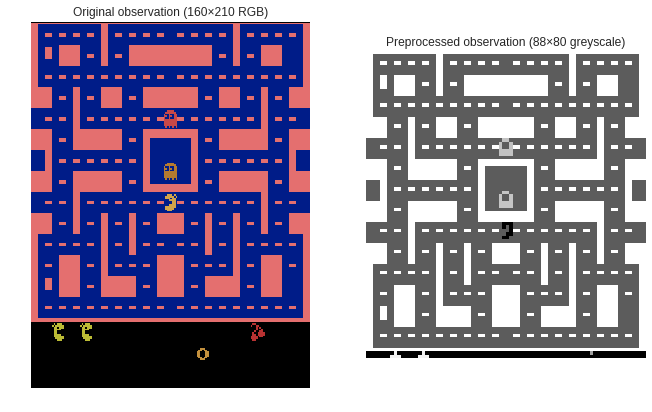

In [12]:
plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("Original observation (160×210 RGB)")
plt.imshow(obs)
plt.axis("off")
plt.subplot(122)
plt.title("Preprocessed observation (88×80 greyscale)")
plt.imshow(img.reshape(88, 80), interpolation="nearest", cmap="gray")
plt.axis("off")

###Build DQN
use a neural network that takes only a state s as inputand outputs one Q-Value estimate per action.

The DQN will be composed of three convolutional layers, followed by two fully connected layers, including the output
layer.

The training algorithm requires two DQNs with the same architecture (but different parameters): one will be used to drive Ms. Pac-Man during training (the *target DQN*), and the other will watch the actor and learn from its trials and errors (the *online DQN*). The online DQN is the one that learns and is copied to the target DQN at regular intervals. The target DQN's only role is to estimate the next state's Q-Values for each possible action. This is needed to compute the target Q-Values for training the online DQN, as shown in this equation:

$y(s,a) = \text{r} + \gamma . \underset{a'}{\max} \, Q_\text{target}(s', a')$

* $y(s,a)$ is the target Q-Value to train the online DQN for the state-action pair $(s, a)$.
* $r$ is the reward actually collected after playing action $a$ in state $s$.
* $\gamma$ is the discount rate.
* $s'$ is the state actually reached after played action $a$ in state $s$.
* $a'$ is one of the possible actions in state $s'$.
* $Q_\text{target}(s', a')$ is the target DQN's estimate of the Q-Value of playing action $a'$ while in state $s'$.

In [0]:
reset_graph()

input_height = 88
input_width = 80
input_channels = 1
conv_n_maps = [32, 64, 64]
conv_kernel_sizes = [(8,8), (4,4), (3,3)]
conv_strides = [4, 2, 1]
conv_paddings = ["SAME"] * 3 
conv_activation = [tf.nn.relu] * 3
n_hidden_in = 64 * 11 * 10  # conv3 has 64 maps of 11x10 each
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n  # 9 discrete actions are available
initializer = tf.variance_scaling_initializer()

In [0]:
def q_network(X_state, name):
    prev_layer = X_state / 128.0 # scale pixel intensities to the [-1.0, 1.0] range.
    with tf.variable_scope(name) as scope:
        for n_maps, kernel_size, strides, padding, activation in zip(
                conv_n_maps, conv_kernel_sizes, conv_strides,
                conv_paddings, conv_activation):
            prev_layer = tf.layers.conv2d(
                prev_layer, filters=n_maps, kernel_size=kernel_size,
                strides=strides, padding=padding, activation=activation,
                kernel_initializer=initializer)
        last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1, n_hidden_in])
        hidden = tf.layers.dense(last_conv_layer_flat, n_hidden,
                                 activation=hidden_activation,
                                 kernel_initializer=initializer)
        outputs = tf.layers.dense(hidden, n_outputs,
                                  kernel_initializer=initializer)
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                       scope=scope.name)
    trainable_vars_by_name = {var.name[len(scope.name):]: var
                              for var in trainable_vars}
    return outputs, trainable_vars_by_name

The **trainable_vars_by_name** dictionary gathers all the trainable variables of this DQN. The keys of the dictionary are the names of the variables, stripping
the part of the prefix that just corresponds to the scope’s name.

Now create the input placehonders:

In [0]:
X_state = tf.placeholder(tf.float32, shape=[None, input_height, input_width,
                                            input_channels])
online_q_values, online_vars = q_network(X_state, name="q_networks/online")
target_q_values, target_vars = q_network(X_state, name="q_networks/target")

copy_ops = [target_var.assign(online_vars[var_name])
            for var_name, target_var in target_vars.items()]
copy_online_to_target = tf.group(*copy_ops)

In [0]:
online_vars

In [0]:
learning_rate = 0.001
momentum = 0.95

with tf.variable_scope("train"):
    X_action = tf.placeholder(tf.int32, shape=[None])
    y = tf.placeholder(tf.float32, shape=[None, 1])
    q_value = tf.reduce_sum(online_q_values * tf.one_hot(X_action, n_outputs),
                            axis=1, keepdims=True)
    error = tf.abs(y - q_value)
    clipped_error = tf.clip_by_value(error, 0.0, 1.0)
    linear_error = 2 * (error - clipped_error)
    loss = tf.reduce_mean(tf.square(clipped_error) + linear_error)

    global_step = tf.Variable(0, trainable=False, name='global_step')
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
    training_op = optimizer.minimize(loss, global_step=global_step)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [0]:
class ReplayMemory:
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.buf = np.empty(shape=maxlen, dtype=np.object)
        self.index = 0
        self.length = 0
        
    def append(self, data):
        self.buf[self.index] = data
        self.length = min(self.length + 1, self.maxlen)
        self.index = (self.index + 1) % self.maxlen
    
    def sample(self, batch_size, with_replacement=True):
        if with_replacement:
            indices = np.random.randint(self.length, size=batch_size) # faster
        else:
            indices = np.random.permutation(self.length)[:batch_size]
        return self.buf[indices]

In [0]:
replay_memory_size = 500000
replay_memory = ReplayMemory(replay_memory_size)

In [0]:
def sample_memories(batch_size):
    cols = [[], [], [], [], []] # state, action, reward, next_state, continue
    for memory in replay_memory.sample(batch_size):
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1)

In [0]:
eps_min = 0.1
eps_max = 1.0
eps_decay_steps = 2000000

def epsilon_greedy(q_values, step):
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs) # random action
    else:
        return np.argmax(q_values) # optimal action

In [0]:
n_steps = 4000000  # total number of training steps
training_start = 10000  # start training after 10,000 game iterations
training_interval = 4  # run a training step every 4 game iterations
save_steps = 1000  # save the model every 1,000 training steps
copy_steps = 10000  # copy online DQN to target DQN every 10,000 training steps
discount_rate = 0.99
skip_start = 90  # Skip the start of every game (it's just waiting time).
batch_size = 50
iteration = 0  # game iterations
checkpoint_path = "./my_dqn.ckpt"
done = True # env needs to be reset

A few variables for tracking progress:

In [0]:
loss_val = np.infty
game_length = 0
total_max_q = 0
mean_max_q = 0.0

And now the main training loop!

In [0]:
with tf.Session() as sess:
    if os.path.isfile(checkpoint_path + ".index"):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
        copy_online_to_target.run()
    while True:
        step = global_step.eval()
        if step >= n_steps:
            break
        iteration += 1
        print("\rIteration {}\tTraining step {}/{} ({:.1f})%\tLoss {:5f}\tMean Max-Q {:5f}   ".format(
            iteration, step, n_steps, step * 100 / n_steps, loss_val, mean_max_q), end="")
        if done: # game over, start again
            obs = env.reset()
            for skip in range(skip_start): # skip the start of each game
                obs, reward, done, info = env.step(0)
            state = preprocess_observation(obs)

        # Online DQN evaluates what to do
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = epsilon_greedy(q_values, step)

        # Online DQN plays
        obs, reward, done, info = env.step(action)
        next_state = preprocess_observation(obs)

        # Let's memorize what happened
        replay_memory.append((state, action, reward, next_state, 1.0 - done))
        state = next_state

        # Compute statistics for tracking progress (not shown in the book)
        total_max_q += q_values.max()
        game_length += 1
        if done:
            mean_max_q = total_max_q / game_length
            total_max_q = 0.0
            game_length = 0

        if iteration < training_start or iteration % training_interval != 0:
            continue # only train after warmup period and at regular intervals
        
        # Sample memories and use the target DQN to produce the target Q-Value
        X_state_val, X_action_val, rewards, X_next_state_val, continues = (
            sample_memories(batch_size))
        next_q_values = target_q_values.eval(
            feed_dict={X_state: X_next_state_val})
        max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
        y_val = rewards + continues * discount_rate * max_next_q_values

        # Train the online DQN
        _, loss_val = sess.run([training_op, loss], feed_dict={
            X_state: X_state_val, X_action: X_action_val, y: y_val})

        # Regularly copy the online DQN to the target DQN
        if step % copy_steps == 0:
            copy_online_to_target.run()

        # And save regularly
        if step % save_steps == 0:
            saver.save(sess, checkpoint_path)

You can interrupt the cell above at any time to test your agent using the cell below. You can then run the cell above once again, it will load the last parameters saved and resume training.

In [0]:
frames = []
n_max_steps = 10000

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)

    obs = env.reset()
    for step in range(n_max_steps):
        state = preprocess_observation(obs)

        # Online DQN evaluates what to do
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = np.argmax(q_values)

        # Online DQN plays
        obs, reward, done, info = env.step(action)

        img = env.render(mode="rgb_array")
        frames.append(img)

        if done:
            break

In [0]:
plot_animation(frames)

In [0]:
plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(ani.to_jshtml())